In [1]:
import numpy as np
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt

In [2]:
log_dir = "/Users/porterjenkins/Downloads/logs"

In [3]:
runs = os.listdir(log_dir)

In [4]:
exp_key = "Beginning experiment"
mcmd_key = "Final MCMD:"
config_key = "Data Config:"
hyper_key = "Hyperparam Config:"

In [5]:
poisson_key = "poisson"
gaussian_key = "gaussian"
ddpn_key = "ddpn"
seitzer_key = "seitzer"

In [6]:
blur_key = 'blur'
mixup_key = 'mixup'
label_noise_key = 'labelnoise'

In [7]:
dta = []
for r in runs:
    stats = []
    if r == ".DS_Store":
        continue
    fpath = os.path.join(log_dir, r, 'log.txt')
    with open(fpath, "r") as f:
        log_rows = f.readlines()    
        for i, l in enumerate(log_rows):
            if i == 0:
                if blur_key in l:
                    stats.append(blur_key)
                elif mixup_key in l:
                    stats.append(mixup_key)
                elif label_noise_key in l:
                    stats.append(label_noise_key)
                else:
                    stats.append("baseline")
            
            val = None
            if exp_key in l:
                val = l.split(exp_key)[-1].strip()
                if poisson_key in val:
                    val = poisson_key
                elif gaussian_key in val:
                    val = gaussian_key
                elif ddpn_key in val:
                    val = ddpn_key
                elif seitzer_key in val:
                    val = seitzer_key
            elif mcmd_key in l:
                val = l.split(mcmd_key)[-1].strip()
            elif config_key in l:
                val = ast.literal_eval(l.split(config_key)[-1].strip())['perturb']
                if isinstance(val, dict):
                    val = val['mean']
                elif val is None:
                    val = 0.0
            elif hyper_key in l:
                val = ast.literal_eval(l.split(hyper_key)[-1].strip())['lmbda']
            if val is not None:
                stats.append(val)
    dta.append(stats)
        

In [8]:
df = pd.DataFrame(dta, columns = ['experiment','head', 'perturb' ,'lambda', 'mcmd'])
df['mcmd'] = df['mcmd'].astype(float)

In [9]:
df[df['experiment']==label_noise_key]

,experiment,head,perturb,lambda,mcmd
1,labelnoise,ddpn,3.0,0.05,0.352022
3,labelnoise,ddpn,5.0,0.05,0.577009
5,labelnoise,ddpn,1.0,0.05,0.116026
8,labelnoise,poisson,4.0,0.05,0.478687
11,labelnoise,poisson,3.0,0.05,0.361172
...,...,...,...,...,...
444,labelnoise,poisson,2.0,0.05,0.238857
448,labelnoise,ddpn,4.0,0.05,0.472291
451,labelnoise,poisson,1.0,0.05,0.113559
455,labelnoise,poisson,4.0,0.05,0.481003


In [10]:
# Remove gaussian
df = df[df['head'] != gaussian_key]

In [11]:
df.to_csv("ood_exp_results.csv", index=False)

In [12]:
summary = df[['experiment','head', 'perturb', 'lambda', 'mcmd']].groupby(['experiment', 'head', 'lambda', 'perturb']).agg(['mean', 'std', 'count'])

In [13]:
summary.reset_index(inplace=True)

In [14]:
summary['head'] = summary['head'].replace(seitzer_key, r"$\beta$-Gaussian (Seitzer '22)")
summary['head'] = summary['head'].replace(ddpn_key, "DDPN (Young '24)")
summary['head'] = summary['head'].replace(poisson_key, 'Poisson')

In [15]:
summary.head()

experiment              head lambda perturb      mcmd                
                                                   mean       std count
0   baseline  DDPN (Young '24)   0.01     0.0  0.120400  0.000511     5
1   baseline  DDPN (Young '24)   0.05     0.0  0.081523  0.002625     5
2   baseline  DDPN (Young '24)   0.10     0.0  0.075788  0.002032     6
3   baseline  DDPN (Young '24)   0.50     0.0  0.056120  0.000510     3
4   baseline  DDPN (Young '24)   1.00     0.0  0.043446  0.001741     3

# Generate OOD Plots

In [16]:
def get_ood_fig(exp_data, fpath, append_xlabel=''):
    plt.figure()
    plt.figure(figsize=(6, 6))
    plt.grid(True)
    for head, head_dta in exp_data.groupby('head'):
        plt.errorbar(
            head_dta['perturb'], 
            head_dta['mcmd']['mean'], 
            yerr=head_dta['mcmd']['std'], 
            fmt='-o', 
            ecolor='black', 
            capsize=5, 
            label=head
        )
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))
    plt.legend(fontsize=14)
    plt.xlabel("Perturbation" + append_xlabel, fontsize=16)
    plt.ylabel(r"$\overline{\mathrm{CCE}}$", fontsize=16)
    plt.savefig(fpath)
    plt.show()
    plt.clf()
    plt.close()

In [17]:
lmbda = 0.05

In [18]:
blur = summary[summary['experiment'].isin(['blur']) & (summary['lambda'] == lmbda)]
mixup = summary[summary['experiment'].isin(['mixup']) & (summary['lambda'] == lmbda)]
labelnoise = summary[summary['experiment'].isin(['labelnoise']) & (summary['lambda'] == lmbda)]

<Figure size 640x480 with 0 Axes>

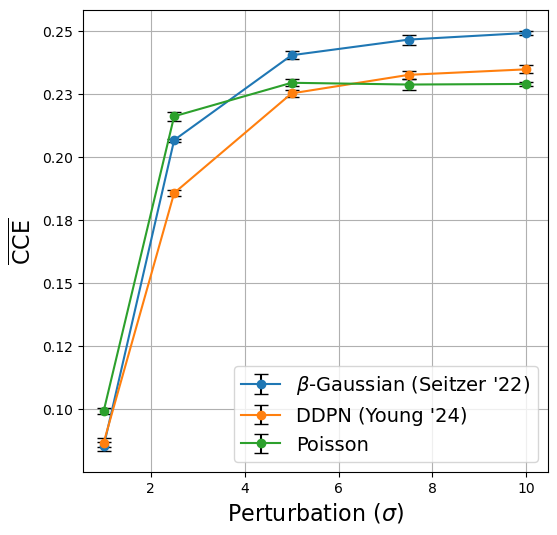

In [19]:
get_ood_fig(blur, 'ood_blur.pdf', append_xlabel=" ($\sigma$)")

<Figure size 640x480 with 0 Axes>

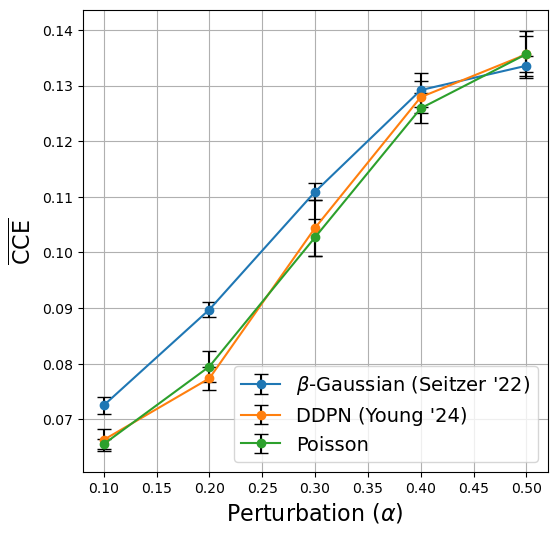

In [20]:
get_ood_fig(mixup, 'ood_mixup.pdf', append_xlabel=r' ($\alpha$)')

<Figure size 640x480 with 0 Axes>

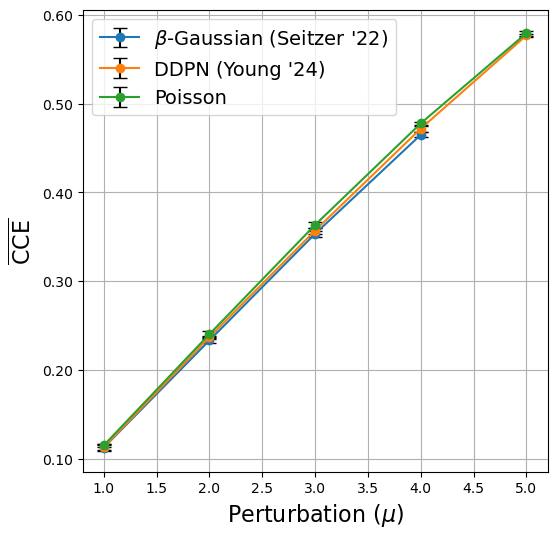

In [21]:
get_ood_fig(labelnoise, 'ood_labelnoise.pdf', append_xlabel=" ($\mu$)")

In [22]:
labelnoise

experiment                            head lambda perturb      mcmd  \
                                                                   mean   
52  labelnoise                DDPN (Young '24)   0.05     1.0  0.112943   
53  labelnoise                DDPN (Young '24)   0.05     2.0  0.236953   
54  labelnoise                DDPN (Young '24)   0.05     3.0  0.357063   
55  labelnoise                DDPN (Young '24)   0.05     4.0  0.471871   
56  labelnoise                DDPN (Young '24)   0.05     5.0  0.576913   
57  labelnoise                         Poisson   0.05     1.0  0.114959   
58  labelnoise                         Poisson   0.05     2.0  0.240273   
59  labelnoise                         Poisson   0.05     3.0  0.363378   
60  labelnoise                         Poisson   0.05     4.0  0.477793   
61  labelnoise                         Poisson   0.05     5.0  0.579423   
62  labelnoise  $\beta$-Gaussian (Seitzer '22)   0.05     1.0  0.112530   
63  labelnoise  $\beta$-Gaussian (Seitzer '22)   0.05     2.0  0.233290   
64  labelnoise  $\beta$-Gaussian (Seitzer '22)   0.05     3.0  0.353374   
65  labelnoise  $\beta$-Gaussian (Seitzer '22)   0.05     4.0  0.464963   

                    
         std count  
52  0.003105     5  
53  0.001620     5  
54  0.003424     5  
55  0.003441     5  
56  0.002121     5  
57  0.002160    10  
58  0.003663    10  
59  0.003009    10  
60  0.002112    10  
61  0.002750    10  
62  0.003492     5  
63  0.002740     5  
64  0.003368     5  
65  0.002959    10

# Effect of Lambda

In [23]:
hyperparam = df[(df['experiment'] == 'baseline')].groupby(["head","lambda"]).head(3).groupby(["head","lambda"]).agg(["mean", "std", "count"]).reset_index()

/var/folders/w5/203pqh9x1h5089n8fqdq8j3w0000gn/T/ipykernel_65029/1852842032.py:1: FutureWarning: ['experiment'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  hyperparam = df[(df['experiment'] == 'baseline')].groupby(["head","lambda"]).head(3).groupby(["head","lambda"]).agg(["mean", "std", "count"]).reset_index()


In [24]:
hyperparam['head'] = hyperparam['head'].replace(seitzer_key, r"$\beta$-Gaussian (Seitzer '22)")
hyperparam['head'] = hyperparam['head'].replace(ddpn_key, "DDPN (Young '24)")
hyperparam['head'] = hyperparam['head'].replace(poisson_key, 'Poisson')

In [25]:
hyperparam

head lambda perturb                 mcmd  \
                                             mean  std count      mean   
0                 DDPN (Young '24)   0.01     0.0  0.0     3  0.120637   
1                 DDPN (Young '24)   0.05     0.0  0.0     3  0.081936   
2                 DDPN (Young '24)   0.10     0.0  0.0     3  0.076575   
3                 DDPN (Young '24)   0.50     0.0  0.0     3  0.056120   
4                 DDPN (Young '24)   1.00     0.0  0.0     3  0.043446   
5                 DDPN (Young '24)   2.50     0.0  0.0     3  0.025508   
6                          Poisson   0.01     0.0  0.0     3  0.084474   
7                          Poisson   0.05     0.0  0.0     3  0.066661   
8                          Poisson   0.10     0.0  0.0     3  0.060897   
9                          Poisson   1.00     0.0  0.0     3  0.035549   
10                         Poisson   2.50     0.0  0.0     3  0.021346   
11  $\beta$-Gaussian (Seitzer '22)   0.01     0.0  0.0     3  0.108715   
12  $\beta$-Gaussian (Seitzer '22)   0.05     0.0  0.0     3  0.079842   
13  $\beta$-Gaussian (Seitzer '22)   0.10     0.0  0.0     3  0.072850   
14  $\beta$-Gaussian (Seitzer '22)   0.50     0.0  0.0     3  0.053434   
15  $\beta$-Gaussian (Seitzer '22)   1.00     0.0  0.0     3  0.040651   
16  $\beta$-Gaussian (Seitzer '22)   2.50     0.0  0.0     3  0.025709   

                    
         std count  
0   0.000346     3  
1   0.003327     3  
2   0.002427     3  
3   0.000510     3  
4   0.001741     3  
5   0.000953     3  
6   0.001137     3  
7   0.001956     3  
8   0.001197     3  
9   0.002203     3  
10  0.000145     3  
11  0.000737     3  
12  0.001763     3  
13  0.002212     3  
14  0.001893     3  
15  0.001106     3  
16  0.001032     3

<Figure size 640x480 with 0 Axes>

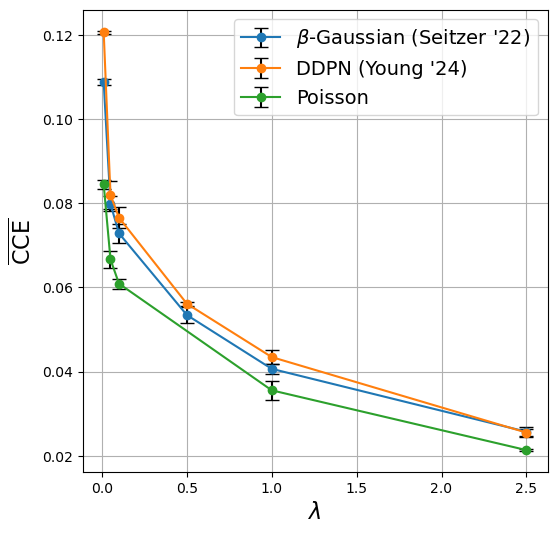

In [26]:
plt.figure()
plt.figure(figsize=(6, 6))
plt.grid(True)
for head, head_dta in hyperparam.groupby('head'):
    plt.errorbar(
        head_dta['lambda'], 
        head_dta['mcmd']['mean'], 
        yerr=head_dta['mcmd']['std'], 
        fmt='-o', 
        ecolor='black', 
        capsize=5, 
        label=head
    )
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))
plt.legend(fontsize=14)
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel(r"$\overline{\mathrm{CCE}}$", fontsize=16)
plt.savefig('coco_lambda_study.pdf')
plt.show()

# Effect of MC Sample Size

In [42]:
mc_df = pd.read_csv("~/Downloads/Prob-cal experiments - hyperparam_mc_samples.csv")

In [43]:
mc_df['head'] = mc_df['head'].replace(seitzer_key, r"$\beta$-Gaussian (Seitzer '22)")
mc_df['head'] = mc_df['head'].replace(ddpn_key, "DDPN (Young '24)")
mc_df['head'] = mc_df['head'].replace(poisson_key, 'Poisson')

In [44]:
mc_summary = mc_df.groupby(['head', 'samples']).agg(['mean', 'std']).reset_index()

In [45]:
mc_summary

head samples      mcmd          
                                                mean       std
0   $\beta$-Gaussian (Seitzer '22)       1  0.063065  0.001041
1   $\beta$-Gaussian (Seitzer '22)       2  0.064147  0.001585
2   $\beta$-Gaussian (Seitzer '22)       3  0.065579  0.001202
3   $\beta$-Gaussian (Seitzer '22)       4  0.063926  0.000697
4   $\beta$-Gaussian (Seitzer '22)       5  0.064068  0.000950
5                 DDPN (Young '24)       1  0.051245  0.003500
6                 DDPN (Young '24)       2  0.051473  0.000952
7                 DDPN (Young '24)       3  0.050592  0.002630
8                 DDPN (Young '24)       4  0.050890  0.002904
9                 DDPN (Young '24)       5  0.048805  0.001911
10                         Poisson       1  0.025832  0.002250
11                         Poisson       2  0.027021  0.002765
12                         Poisson       3  0.026286  0.002036
13                         Poisson       4  0.026467  0.001456
14                         Poisson       5  0.027149  0.000766

<Figure size 640x480 with 0 Axes>

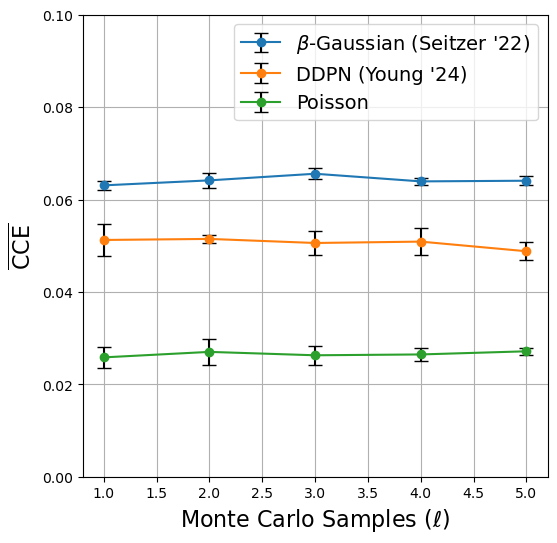

In [47]:
plt.figure()
plt.figure(figsize=(6, 6))
plt.grid(True)
plt.ylim(0, 0.1)
for head, head_dta in mc_summary.groupby('head'):
    plt.errorbar(
        head_dta['samples'], 
        head_dta['mcmd']['mean'], 
        yerr=head_dta['mcmd']['std'], 
        fmt='-o', 
        ecolor='black', 
        capsize=5, 
        label=head
    )
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))
plt.legend(fontsize=14)
plt.xlabel(r"Monte Carlo Samples $(\ell) $", fontsize=16)
plt.ylabel(r"$\overline{\mathrm{CCE}}$", fontsize=16)
plt.savefig('aaf_monte_carlo_study.pdf')
plt.show()